## Strain data analysis

In [733]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [734]:
import regimes
import numpy as np
import pandas as pd
import seaborn as sns
from clasp import ClaSP
import datasets as dataset
from scipy import stats
from spdms import getSPDMs
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

np.random.seed(1)

In [735]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [736]:
# Normalization (Standard)
def normalize(data, type='minmax'):

    if type=='std':
        return (np.array(data) - np.mean(data))/np.std(data)
        
    elif type=='minmax':
        return (np.array(data) - np.min(data))/(np.max(data) - np.min(data))

In [737]:
def difference_dataframe(df, interval=1):
    """
    Applies differencing to all columns of a DataFrame while maintaining timestamps.

    Parameters:
        df (pandas.DataFrame): The input DataFrame with timestamps as index.
        interval (int): The differencing interval. Default is 1.

    Returns:
        pandas.DataFrame: DataFrame with differenced values and timestamps.
    """
    # Extract timestamps if they are set as index
    timestamps = df.index
    
    # Apply differencing to all columns
    diff_df = df.apply(lambda x: np.diff(x, n=interval))
    
    # Restore timestamps to the differenced DataFrame
    diff_df.index = timestamps[1:]  # We lose one timestamp due to differencing
    
    return diff_df


In [738]:
# Function to convert timestamp to formatted date
def convert_timestamp(timestamp):
    # Assuming the timestamp format is 'YYMMDD'
    timestamp = str(timestamp)
    year = int(timestamp[:4])
    month = int(timestamp[4:6])
    day = int(timestamp[6:8])

    # Convert to datetime object
    date_obj = datetime(year, month, day)

    # Format the datetime object as 'DD-Mon-YYYY'
    formatted_date = date_obj.strftime('%d-%b-%Y')

    return formatted_date

In [739]:
def add_date_column(dataframe, starting_date):
    """
    Add a 'date' column to the DataFrame based on the 'day' column and starting date.

    Parameters:
    - dataframe: DataFrame with a 'day' column representing the day of the year.
    - starting_date: Starting date in the format 'DD-MMM-YYYY' (e.g., '01-Jan-2001').

    Returns:
    - DataFrame with the added 'date' column.
    """
    # Number of samples in the data
    num_samples = len(dataframe)

    # Convert the starting date to a datetime object
    start_date = pd.to_datetime(starting_date, format="%d-%b-%Y")

    # Add a new 'date' column based on 'day', 'month', and dynamically assigned 'year'
    dataframe['Date'] = (start_date + pd.to_timedelta(dataframe.index, unit='D')).strftime("%d-%b-%Y")

    return dataframe

In [740]:
# Function to trim time part from date string and use month names abbreviation
def trim_time_and_format(date_string):
    datetime_object = datetime.strptime(date_string, "%d-%b-%Y") # "%Y-%m-%d %H:%M:%S"
    return datetime_object #.strftime("%Y %b")

In [741]:
# Load data
file_path = r"../datasets/moxa/moxa_data_D.csv"
data = regimes.read_file(file_path)
print(data.columns)

col_list = ['DateTime', 'temperature_outside', 'pressure_outside', 'wind_x',  'winx_y', 'humidity', 'glob_radiaton']
# col_list = ['DateTime', 'temperature_outside',b 'pressure_outside', 'wind_x', 'wind_y', 'humidity', 'glob_radiaton']

data = data[:][col_list]
data.rename(columns={'temperature_outside': 'T', 'pressure_outside': 'P', 'glob_radiaton': 'R$_g$', 'strain_ns_corrected':'Strain$_{ns}$',  'strain_ew_corrected':'Strain$_{ew}$', 'gw_mb':'GW$_{mb}$', 'gw_sg':'GW$_{sg}$', 'wind_x': 'Wind$_{ew}$', 'winx_y': 'Wind$_{ns}$', 'humidity': 'Humidity'}, inplace=True)

Index(['DateTime', 'rain', 'temperature_outside', 'pressure_outside', 'gw_mb',
       'gw_sr', 'gw_sg', 'gw_west', 'gw_knee', 'gw_south', 'wind_x', 'winx_y',
       'snow_load', 'humidity', 'glob_radiaton', 'strain_ew_uncorrected',
       'strain_ns_uncorrected', 'strain_ew_corrected', 'strain_ns_corrected',
       'tides_ew', 'tides_ns'],
      dtype='object')


In [742]:
data.isnull().sum()

DateTime       0
T              2
P              2
Wind$_{ew}$    2
Wind$_{ns}$    2
Humidity       2
R$_g$          2
dtype: int64

In [743]:
data = data.fillna(method='pad')
# data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DateTime     1096 non-null   object 
 1   T            1096 non-null   float64
 2   P            1096 non-null   float64
 3   Wind$_{ew}$  1096 non-null   float64
 4   Wind$_{ns}$  1096 non-null   float64
 5   Humidity     1096 non-null   float64
 6   R$_g$        1096 non-null   float64
dtypes: float64(6), object(1)
memory usage: 60.1+ KB


In [744]:
# Convert datetime column to datetime type
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Extract year, month, day, and hour components
data['DateTime'] = data['DateTime'].dt.strftime('%Y-%m-%d')

data = data.set_index('DateTime')
data = data.apply(normalize)

data_corr = data_corr.set_index('DateTime')
data_corr = data_corr.apply(normalize)

In [745]:
data.index[-1]

'2017-10-31'

In [746]:
data.isnull().sum()

T              0
P              0
Wind$_{ew}$    0
Wind$_{ns}$    0
Humidity       0
R$_g$          0
dtype: int64

<Figure size 3000x800 with 0 Axes>

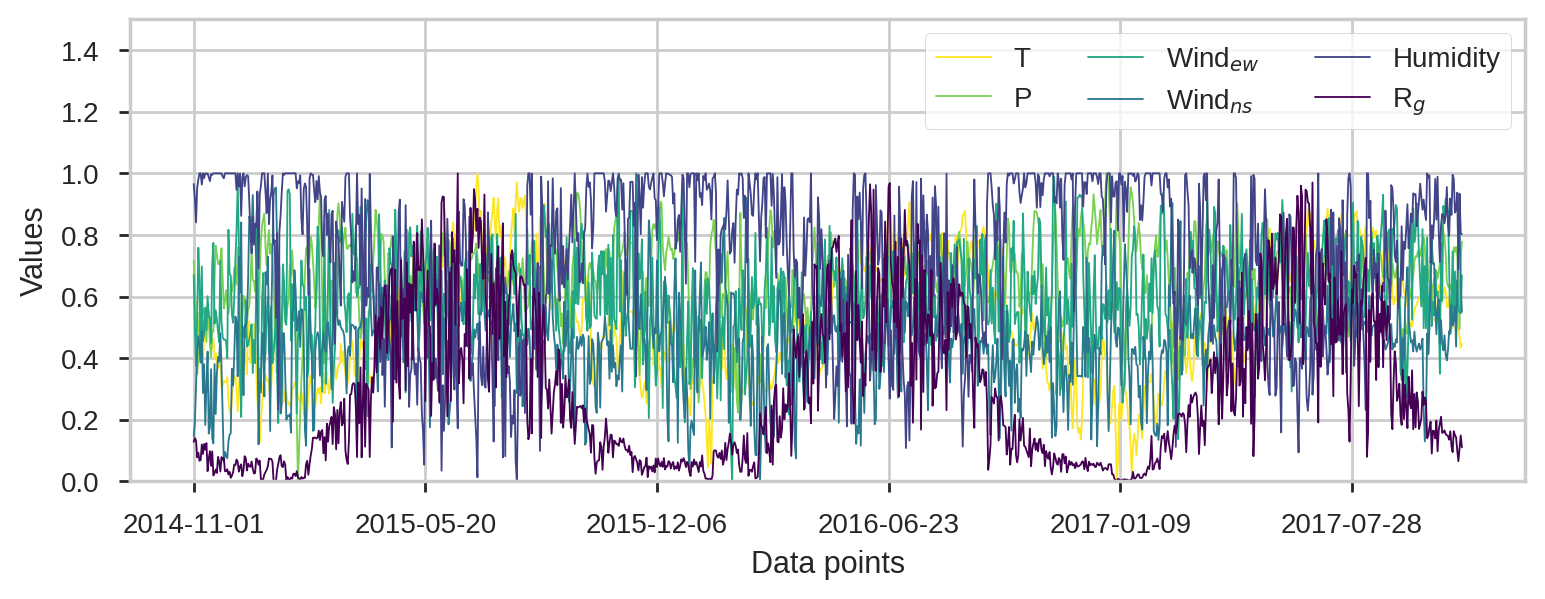

In [747]:
toplot = ['temperature_outside', 'strain_ew_corrected', 'strain_ns_corrected']
toplot = data.columns[:]

plt.figure(figsize=(15, 4))
ax = data[toplot].plot(cmap='viridis_r', figsize=(9, 3), linewidth=0.66)
ax.tick_params(length=4)
plt.legend(toplot, loc='upper right', frameon=True, ncol=3)
plt.xlabel('Data points')
plt.ylabel('Values')
plt.ylim(0, 1.5)
# plt.savefig("../res/extended_regimes.pdf", bbox_inches='tight')
plt.show()

In [748]:
# Desired number of clusters. Set k=None to let the algorithm aumotically find opitmal k.
k = 2   # k=None, 3

# Sliding window size
winsize = 30      # 3500 # 155, 150

# distance metrics
metricE = 'Euclidean'
metricR = 'Riemannian'

# Specify reduced dimension size, default is dim='full' for no dimension reduction.
dim = 'full' 

# Retrieve regimes with their corresponding indices
clusters, cluster_idx, adjusted_idx, *_ = regimes.get_regimes(data, winsize, metricR, k, dim)
print(adjusted_idx)

Regimes:(1, 0) (1, 30) (1, 60) (1, 90) (1, 120) (0, 150) (0, 180) (0, 210) (0, 240) (0, 270) (1, 300) (1, 330) (1, 360) (1, 390) (1, 420) (1, 450) (1, 480) (0, 510) (0, 540) (0, 570) (0, 600) (0, 630) (0, 660) (1, 690) (1, 720) (1, 750) (1, 780) (1, 810) (1, 840) (0, 870) (0, 900) (0, 930) (0, 960) (0, 990) (1, 1020) (1, 1050)
[0, 150, 300, 510, 690, 870, 1020]


{'Regime 1': '2014-11-01', 'Regime 2': '2014-12-01', 'Regime 3': '2014-12-31', 'Regime 4': '2015-01-30', 'Regime 5': '2015-03-01', 'Regime 6': '2015-03-31', 'Regime 7': '2015-04-30', 'Regime 8': '2015-05-30', 'Regime 9': '2015-06-29', 'Regime 10': '2015-07-29', 'Regime 11': '2015-08-28', 'Regime 12': '2015-09-27', 'Regime 13': '2015-10-27', 'Regime 14': '2015-11-26', 'Regime 15': '2015-12-26', 'Regime 16': '2016-01-25', 'Regime 17': '2016-02-24', 'Regime 18': '2016-03-25', 'Regime 19': '2016-04-24', 'Regime 20': '2016-05-24', 'Regime 21': '2016-06-23', 'Regime 22': '2016-07-23', 'Regime 23': '2016-08-22', 'Regime 24': '2016-09-21', 'Regime 25': '2016-10-21', 'Regime 26': '2016-11-20', 'Regime 27': '2016-12-20', 'Regime 28': '2017-01-19', 'Regime 29': '2017-02-18', 'Regime 30': '2017-03-20', 'Regime 31': '2017-04-19', 'Regime 32': '2017-05-19', 'Regime 33': '2017-06-18', 'Regime 34': '2017-07-18', 'Regime 35': '2017-08-17', 'Regime 36': '2017-09-16'}


<Figure size 3000x800 with 0 Axes>

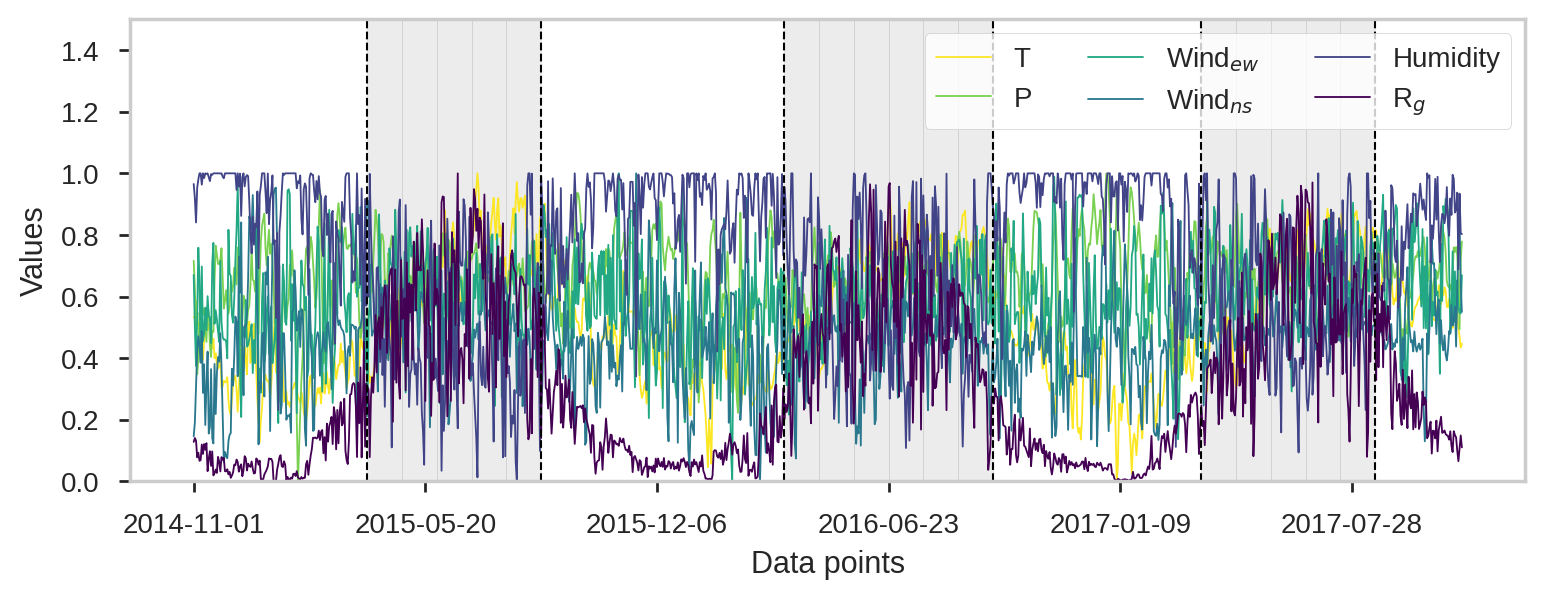

In [749]:
var_to_plot = data.columns[:]
regimes.visualize(data, var_to_plot, clusters, cluster_idx, winsize, dtype='real')

In [750]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

def is_last_element(lst, element):
    return lst.index(element) == len(lst) - 1

# Define the split points with different interval lengths
split_points = adjusted_idx[:]

# Define a function to calculate Spearman correlation and p-value for each segment
def calculate_correlation(data, split_points):
    results = {}
    start_idx = split_points[0]
    for i, split_point in enumerate(split_points):
        segment_name = f"Segment {i+1}"
        segment_results = {}
        
        if is_last_element(split_points, split_point):
            segment_data = data.iloc[start_idx : -1]
        else:
            segment_data = data.iloc[start_idx : split_points[i+1]]
        # print(segment_data.corr())
        print(f'Segment: {segment_name}')
        for var in data.columns[0:2]:
            corr_pvals = {}
            cval, pval = [], []
            for other_var in data.columns[2:]:
                
                corr, p_val = spearmanr(segment_data[var], segment_data[other_var])
                corr, p_val = round(corr, 2), round(p_val, 2)
                corrcoeff = np.corrcoef(segment_data[var], segment_data[other_var])
                # print(f'Corr coefficient Strain-NS, {other_var}: {corrcoeff[0][1]}')
                
                cval.append(corr)
                pval.append(p_val)
                corr_pvals[other_var] = {'corr': corr, 'p-value': p_val}
            

            print(f'Variable: {var}')
            print(f'Corr: {cval}')
            print(f'p-val: {pval}')
            
            segment_results[var] = corr_pvals
        results[segment_name] = segment_results
        start_idx = split_point
    return results

# Calculate Spearman correlation and p-value for each segment
corr_pval_results = calculate_correlation(data, split_points)

# Print the results
for segment, segment_data in corr_pval_results.items():
    print(segment)
    for var, corr_pvals in segment_data.items():
        print(f"  Variable: {var}")
        for other_var, values in corr_pvals.items():
            print(f"    {other_var}: Corr = {values['corr']}, p-value = {values['p-value']}")


Segment: Segment 1
Variable: T
Corr: [-0.11, 0.3, -0.26, 0.31]
p-val: [0.17, 0.0, 0.0, 0.0]
Variable: P
Corr: [0.2, -0.01, 0.05, 0.14]
p-val: [0.02, 0.94, 0.54, 0.09]
Segment: Segment 2
Variable: T
Corr: [0.1, 0.2, -0.72, 0.79]
p-val: [0.09, 0.0, 0.0, 0.0]
Variable: P
Corr: [0.17, -0.07, -0.13, 0.2]
p-val: [0.0, 0.23, 0.03, 0.0]
Segment: Segment 3
Variable: T
Corr: [0.11, 0.19, -0.67, 0.75]
p-val: [0.04, 0.0, 0.0, 0.0]
Variable: P
Corr: [0.13, -0.16, 0.03, 0.01]
p-val: [0.01, 0.0, 0.56, 0.87]
Segment: Segment 4
Variable: T
Corr: [0.17, 0.13, -0.59, 0.73]
p-val: [0.0, 0.01, 0.0, 0.0]
Variable: P
Corr: [0.18, -0.03, 0.0, -0.0]
p-val: [0.0, 0.52, 0.96, 0.98]
Segment: Segment 5
Variable: T
Corr: [0.06, 0.2, -0.64, 0.8]
p-val: [0.27, 0.0, 0.0, 0.0]
Variable: P
Corr: [0.33, -0.19, 0.16, -0.18]
p-val: [0.0, 0.0, 0.0, 0.0]
Segment: Segment 6
Variable: T
Corr: [0.16, 0.4, -0.66, 0.83]
p-val: [0.0, 0.0, 0.0, 0.0]
Variable: P
Corr: [0.29, -0.3, 0.16, -0.16]
p-val: [0.0, 0.0, 0.0, 0.0]
Segment: Se